<a href="https://colab.research.google.com/github/kircherlab/MPRAsnakeflow_tutorial/blob/main/tutorial_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import matplotlib.pyplot as plt
import os

# MPRAsnakeflow assignment tutorial

This notebook is used to assign the barcodes to the sequences and to create a final file which maps barcodes to designed oligos, like `example_data/assignment/assignment_barcodes.default.tsv.gz`.

After going through the pre-requirements we will cover the config file, run MPRAsnakeflow and look at interesting results like average numer of barcodes per oligo.

## Pre-requirements

### Docker/uDocker/apptainer

When running locally you need to install `docker` or `apptainer`. For running it remotly on google colab `udocker` in colab from github.com/drengskapur/docker-in-colab works nicely.

We try to atomatically find out what you need:

In [2]:
tutorial_container = "visze/mprasnakeflow_tutorial:0.1.0"
docker= False
apptainer = False

docker = !docker --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
docker = bool(int(docker[0]))
apptainer = !apptainer --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
apptainer = bool(int(apptainer[0]))

if docker:
    print("Docker is installed! We will use Docker to run MPRAsnakeflow")
elif apptainer:
    print("Apptainer is installed! We will use Apptainer to run MPRAsnakeflow")
else:
    print("Neither Docker nor Apptainer is installed. We assume you run the tutorial on colab and we will install uDocker for colab")

Docker is installed! We will use Docker to run MPRAsnakeflow


When neither Docker nor Apptainer is installed we will install udocjer for colab now.

In [3]:
def udocker_init():
    import os
    if not os.path.exists("/home/user"):
        !pip install udocker > /dev/null
        !udocker --allow-root install > /dev/null
        !useradd -m user > /dev/null
    print(f'Docker-in-Colab 1.1.0\n')
    print(f'Usage:     udocker("--help")')
    print(f'Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples')

    def execute(command: str):
        user_prompt = "\033[1;32muser@pc\033[0m"
        print(f"{user_prompt}$ udocker {command}")
        !su - user -c "udocker $command"

    return execute

if not docker and not apptainer:
    udocker = udocker_init()

We define a general function to run our MPRAsnakeflow tutorial container that will check if docker, apptainer or uDocker has to be run. It will also bind your data directory `${{PWD}}/MPRAsnakeflow_tutorial` (will be dowloaded later) to `/data/run` within the container and defines this as working directory.

In [4]:
def runContainer(command):
    user_prompt = "\033[1;32muser@pc\033[0m"
    if docker:
        print(f"{user_prompt}$ docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}")
        !docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}
    elif apptainer:
        print(f"apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}")
        !apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}
    else:
        udocker(f"run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run mprasnakeflow_tutorial {command}")

### Test data

The data used in this tutorial is present in the github repository. We will dowload it using git so that it is also present within a colab environment.

In [5]:
%%bash
git clone https://github.com/kircherlab/MPRAsnakeflow_tutorial.git

Cloning into 'MPRAsnakeflow_tutorial'...


### snakemake

MPRAsnakeflow and its software dependencies is packed in the official snakemake v8.20.3 container and you can find it on dockerhub wih the tag [`visze/mprasnakeflow_tutorial:0.1.0`](https://hub.docker.com/r/visze/mprasnakeflow_tutorial).

In [6]:
if docker:
    print(f"docker pull {tutorial_container}")
    !docker pull "{tutorial_container}"
    print(f"docker create --name=mprasnakeflow_tutorial {tutorial_container}")
    !docker create --name=mprasnakeflow_tutorial "{tutorial_container}" > /dev/null
elif apptainer:
    print(f"apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container}")
    !apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container} > /dev/null
else:
    udocker(f"pull {tutorial_container}")
    udocker(f"create --name=mprasnakeflow_tutorial {tutorial_container}")

docker pull visze/mprasnakeflow_tutorial:0.1.0
0.1.0: Pulling from visze/mprasnakeflow_tutorial
Digest: sha256:429d73bdc2e8bd5fbc576f86f954df1d8400def86fc9e6b48890f356efa13fa9
Status: Image is up to date for visze/mprasnakeflow_tutorial:0.1.0
docker.io/visze/mprasnakeflow_tutorial:0.1.0
docker create --name=mprasnakeflow_tutorial visze/mprasnakeflow_tutorial:0.1.0
Error response from daemon: Conflict. The container name "/mprasnakeflow_tutorial" is already in use by container "b877cf88740dce02088c0fb4ce7e5b1156d6311e5a1f77bc8cdf2e9e6993ac34". You have to remove (or rename) that container to be able to reuse that name.


Try to run `snakemake --version` in docker:

In [7]:
runContainer("snakemake --version")

user@pc$ docker run -v=${PWD}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run visze/mprasnakeflow_tutorial:0.1.0 snakemake --version
8.20.3+0.ge9ce4a3c.dirty


## Assignment workflow

To analyze your MPRA data, you need to know which barcode goes with which tested sequence. This is called assignment and typically associated multiple barcodes (i.e. the sequences that you will later count in the MPRA experiment) to a target sequence. It is possible that you already designed your assignment in advance (e.g. have barcodes synthezied with the targeted sequences) and already have a file which holds for each of the designed sequences the assignment to the barcodes. If this is the case you do not need to run the assignment step again and can run the experiment workflow with the file you already have.\
For the assignment step, we will need the files in the assignment folder (sequencing of barcodes and of the target sequences), as well as the config file and the design fasta (target sequences) in the design folder. We will take a look at these files now. The structure of a fastq file is as follows:  


```
@Sequence_ID_1  
Sequence_1  
+(Sequence_ID_1)  
Quality score string of Sequence_1
@Sequence_ID_2  
Sequence_2  
+(Sequence_ID_2)
Quality score string of Sequence_2  
...
```


In [8]:
print("First two barcodes in our barcode sequencing file:\n")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR <=8 {print $0}'

print("\nFirst two sequences in our forward sequencing file:\n")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_fwd.fastq.gz" | awk 'NR <=8 {print $0}'

First two barcodes in our barcode sequencing file:

@NS500466:861:HT5LLAFX3:1:11101:4277:1067 2:N:0:ACGTAGACCA
TTGAGACGCCGTGAC
+
AAAAAEAEEEEEEEE
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 2:N:0:ACGTAGACCA
GCAGATGTAGATTGT
+
AAAAAEEEEEEEEEE

First two sequences in our forward sequencing file:

@NS500466:861:HT5LLAFX3:1:11101:4277:1067 1:N:0:ACGTAGACCA
TCCTTTGTCTTCATTACTTGTCTCACTGGTGCAGGCCTCGCTTAGCTTTCAGCCTATCGCAGCTTTCAACCTGCCTTCCTTGCTAAGCTGAATCATTTCTGGGTTTTGATTTAAAGTGAGTCGTCGTGGCTCTTCCTTTGAGCACT
+
AAAAAEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAEEEEAEEEEEE<EEEEAEEEEEEEEEEAEEEEEEAAE<EEEEEEEEEEAEEEEEEEEAEEEEEEEEAEEEEEEEEEEAE/EEEAEEAE<EEEEAAEEEAAE<A<A
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 1:N:0:ACGTAGACCA
TATGGTTTGGCTGTGTTCCTACCCAAATCTCATCTTGAATTGTAGCTCCCACAATTCCCATGTCATGGGAGGGACCAAGTGGGAGGTAACTGAATCAGGCGGCGGGTCTTACCCCATACTGTTCTCTTGGTAGTGAATAAGTCTCA
+
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEEE<EEEEEEEEEEEEEAEEAAEEEAEEEEAEEEEEEEEEEEE<A<<<EAEEEEEEE6AAEEEEEEEEEEEEEEEE<EEEE<EAEEEA

If you take a good look at these files, you can see the sequence IDs in lines starting with the "@". By definition the sequence ID ends at the first white space (remainder is considered a comment). This sequence ID is identical between the different files, i.e. the forward, reverse and barcode reads from the same molecule are in the same order. From the combination of these files, we can see which barcode is associated with which sequenced target (forward/reverse reads). These sequenced forward/reverse reads should therefore correspond to the sequences that we designed. The designed sequences can be found in our design fasta, which contains the following information:  

```
>oligo_ID_1  
Designed sequence 1
>oligo_ID_2  
Designed sequence 2
...
```




In [9]:
!head "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa"

>oligo_002500
AGGACCGGATCAACTCTGATTGCCTGCACCTAGATGGCTTGTGTGTAGCAGGGGCTCCTGGATGAGAAGGGGGCAGAAGTTAATAGAGCTGACTCGTGCCTTGAGTGTCATGTCTTATGTATTCAGCTGCTGACTAAGCAGCAGAGTGTAATATAGCTTACTAGAAAAAGTTGACCTTTAGCTGCATTCTTAATTCTTAACTTTTCAGTTATTGACATTGCGTGAACCGA
>oligo_002501:oligo_002502
AGGACCGGATCAACTGGTAATTTATAGATTCAATGCCATCCCCATCAAGCTACCAATGACTTTCTTCCCAGAATTAGAAAAAACTACTTTAAAGTTCATATGGAACCAAAAAAGAGCCCGCATCGCCAAGTCAATCCTAAGCCAAAAGAACAAAGCTGGAGGCATCACGCTACCTGACTTCAAACTATACTACAAGGCTATGGAAATTATTTTTACATTGCGTGAACCGA
>oligo_002503
AGGACCGGATCAACTAACCTCACAATGAATCAGTGAGGTTCATATTGTTCTCCCCATTTTACAAAAAAGAGAGGTTCAGATAAATTCAGTAATTTTCTCAAGGTCACAGAACAAGTAAAGAACACAGGAGTAGTAAAAAACAGAACCAAGACTGGGACACAAGCCTCCAGCCTCCCTGGCTCAGAGCCCCTTGCTGTCTCCACTATGCCCACCATCATTGCGTGAACCGA
>oligo_002504
AGGACCGGATCAACTAGAGGCCCTGAAGAAAGGGGAAAAAGGCAGTGAAGGGGCAGAAACCCTGGTAGTCCAGCAAGGGAGGGTGAGAAGGAAGGGGGGAGGTATGAGTATTACTATAGACCAAGGGTTGGGGTGGCACCTGGAGACTCCTGGACTTGACTGCAACTGTATGTATTGTTATATGTATATGTATAGACATTTATTTTCAAGTATATCATTGCGTGAACCGA
>oligo_

"Oligos" are the target sequences that we designed in advance, i.e. the sequences we would like to see in our assignment sequencing files (fastq files). In the association step, our goal is to assign the sequences to the oligos, since as you can see the oligo ID and sequence ID are not matching. By matching the reads to our designed oligos, we also automatically link the sequenced barcodes to our designed oligos, which is essential for us later.

## Run MPRAsnakeflow




### Snakemake

Before we come to more MPRAsnakeflow pipeline specific things we quickly want to introduce the snakemake workflow management system. A workflow management system, also like nextflow or cwl, is a tool to create reproducible and scalable data analyses. Snakemake workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition. Finally, Snakemake workflows can entail a description of required software, which will be automatically deployed to any execution environment.

Each step in snakemake is defined as a `rule`. Which has a `input`, `output` and a mostly `shell` command. The `input` and `output` are files that are used as input and output for the rule. The `shell` command is the command that is executed to create the output file from the input file. There are other commands like `conda`, `params`, `log`, `threads`, `resources` that can be used to define the rule.

E.g. here is an example rule `assignment_check_design` of MPRAsnakeflow, which checks if the design file is correct (no duplicated header, no `[` or `]` within headers and no duplicates sequences (sense and antisense). The rule takes our design file defined in the config (see later) and a script as input. When it is completed it creates the file `results/assignment/{assignment}/design_check.done` and other rules will only start running when this file is present and the check is completed. `{assignment}` is a wildcard and the name of the assignment will be used here (defined in the config file). This allows us to define multiple assignments within the config file an run them in parallel. In addition the design file is copied here: `results/assignment/{assignment}/reference/reference.fa` so that further mapping rules can create their mapping reference files. You see the `params` command is a bit lengthy but we needed some conditions, based on the flexibility of the user input. But finally the `shell` command looks very clean.

```python
rule assignment_check_design:
    """
    Check if the design file is correct and no duplicated sequences are present (FW and reverse).
    Also check if no duplicated headers and no illegal characters in header.
    """
    conda:
        "../envs/python3.yaml"
    input:
        design=lambda wc: config["assignments"][wc.assignment]["design_file"],
        script=getScript("assignment/check_design_file.py"),
    output:
        temp("results/assignment/{assignment}/reference/reference.fa.fxi"),
        touch("results/assignment/{assignment}/design_check.done"),
        ref="results/assignment/{assignment}/reference/reference.fa",
    params:
        start=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]["max"]
        ),
        length=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]["min"]
        ),
        fast_check=lambda wc: (
            "--fast-dict"
            if config["assignments"][wc.assignment]["design_check"]["fast"]
            else "--slow-string-search"
        ),
        check_sequence_collitions=lambda wc: (
            "--perform-sequence-check"
            if config["assignments"][wc.assignment]["design_check"][
                "sequence_collitions"
            ]
            else "--skip-sequence-check"
        ),
    log:
        log=temp("results/logs/assignment/check_design.{assignment}.log"),
        err="results/assignment/{assignment}/design_check.err",
    shell:
        """
        trap "cat {log.err}" ERR
        cp {input.design} {output.ref}
        python {input.script} --input {output.ref} \
        --start {params.start} --length {params.length} \
        {params.fast_check} {params.check_sequence_collitions} > {log.log} 2> {log.err};
        """
```


When running snakemake you need to specify where your worflow is, basically the main `Snakefile` of it. By default, Snakemake will search for ‘Snakefile’, ‘snakefile’, ‘workflow/Snakefile’, ‘workflow/snakefile’ beneath the current working directory, in this order. Then you do not have to use this command. But practically your workflow, here MPRAsnakeflow, might live somewhere else and you want to run the workflow in a different directory where you want to produce results. Then you need to specify the `--snakefile` parameter to the MPRAsnakeflow file in `workflow/Snakefile`. Otherwise you ahve to check/copy the workflow in every "run" rirectory which is not practically. Usually you start snakemake in the directory where you want to produce results.

### The config file

The heart of your workflow run is the config file. You can specify it via `--configfile`. It is in `yaml` or `json` format. It contains all the parameters and input files that are used in the workflow.

The config file has many parameters. But most of them have a default well, based on best practice and you don't have to specify them. But you can overwrite them if you want. Config files are first validated using json schema. If your config file is not correct MPRAsnakeflow will tell you what is missing or wrong and stop. Naming, parameters etc. might change from MPRAsnakeflow version and you might have to update your config file if you run a new version of MPRAsnakeflow. An extensive documentation of the config file can be found in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/development/config.html).

Here is the config file that we will use for running the association tutorial.



```yaml
---
# global:
#   assignments:
#     split_number: 30
assignments:
  assignMPRAworkshop:
    bc_length: 15
    alignment_tool:
        tool: bbmap
        configs:
          sequence_length:
            min: 195
            max: 205
          alignment_start:
            min: 14
            max: 16
    FW:
      - example_data/assignment/assoc_fwd.fastq.gz
    BC:
      - example_data/assignment/assoc_bc.fastq.gz
    REV:
      - example_data/assignment/assoc_rev.fastq.gz
    design_file: example_data/design/workshop_design.fa
    configs:
      default: {}
```

Because we run the assignment workflow we start with `assignment`. The a list with possible names of assignments will follow. Here we have just one: `assignMPRAworkshop`. The whole config file has the minimal information, which is needed by MPRAsnakeflow. This is the barcode length `bc_length`, the alignment tool `alignment_tool` for mapping reads to the design file (here we use `bbmap` but other options are possible) and the configuration of the tool. The forward reads `FW`, the barcode reads `BC`, the reverse reads `REV` and the design file `design_file`. Then we can define multiple configs `configs`, basically how we filter barcodes later. E.g. a minimal support of barcodes per oligo `min_support` and a fraction of assigned barcodes to an oligo `fraction`. In our tutorial example we just have one config named `default` and we will set the default parameters by defining `degault: {}`. This is `min_support: 3` and `fraction: 0.75`. But the option to have multiple settings allows us to create multiple BC to oligo mappings based on different strategies. The worflow will then only run the last part multiple times with different settings avoiding the computational extensive mapping approach.

As a sanity check and to understand where these values come from, we will take a look at if the information matches our input files. We used 15 bp adapters for this MPRA experiment, which were added at both ends of each designed oligo. The ``alignment_start`` configuration refers to these adapters as our actual target sequences only starts after the 15 bp of adapter sequence.

In [10]:
adapter_length=15

print("\nAverage length of a barcode:")
!zcat "MPRAsnakeflow_tutorial/example_data/assignment/assoc_bc.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'

print("\nAverage length of a target sequence (oligo length - 2 x adapter):")
seq_length_with_bc = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | awk 'NR % 4 == 2 {{sum +=length($$0)}} END {{print sum*4/NR}}'
seq_length_with_bc = int(seq_length_with_bc[0])
seq_length = seq_length_with_bc - 2*adapter_length
print(seq_length)


Average length of a barcode:
15

Average length of a target sequence (oligo length - 2 x adapter):
200


### MPRAsnakeflow tutorial profile

Snakemake can make use of profiles to pre-configure command-line-interfaces as well as ressources and number of threads as default or per rule. A profile has to be stored (on Linux) in the folder `$HOME/.config/snakemake` or `/etc/xdg/snakemake`. It can be activated by using the `--profile` option in the snakemake command. In addition you can set an environment variable `SNAKEMAKE_PROFILE`, e.g. by specifying export `SNAKEMAKE_PROFILE=myprofile` in your `~/.bashrc` to use the profile by default. In addition a specific workflow profile can be set using `--workflow-profile path_to_your_profile`. E.g. we pre-defined a [workflow profile for MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow/blob/development/profiles/default/config.yaml) adding ressources to each rule with some additional commands for the [snakemake excecutor plugin slum](https://snakemake.github.io/snakemake-plugin-catalog/plugins/executor/slurm.html).

For more information on snakemake using profiles please have a look [snakemke profile documentation](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles)

For the MPRAsnakeflow tutorial we will use the profile `mprasnakeflow` which is stored in the folder `/etc/xdg/snakemake` within the container and the `SNAKEMAKE_PROFILE=mprasnakeflow` is already set. Have a look at the variable and the profile:

In [11]:
runContainer("cat /etc/xdg/snakemake/mprasnakeflow/config.yaml")

user@pc$ docker run -v=${PWD}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run visze/mprasnakeflow_tutorial:0.1.0 cat /etc/xdg/snakemake/mprasnakeflow/config.yaml
---
snakefile: /data/MPRAsnakeflow/workflow/Snakefile
software-deployment-method: conda
conda-prefix: /data/conda_envs
cores: 1
set-threads:
  assignment_mapping_bbmap: 10


You see that we already defined where the MPRASsnkeflow `Snakefile` is and `--snakefile` is not necessary. Also all software packages are installed alrady in the container using conda and we enable this software deployment method and tell snakemake where the conda environments live (the default will be your exceuction folder under `.snamemake/conda`). Also the `--cores/-c` option is not necessary anymore and snakemake just needs your configuration file of the workflow using the command `--configfile`

### Run the workflow

First we run a dry-run to see what will be executed using `-n` and `--quiet rules` to see only the overview of excecuted rules and not each rule command individually. The most important part is setting the config file via `-configfile config_assignment.yaml`

In [12]:
# MPRAsnakeflow_tutorial must be accessable and writable for all (and docker)
!chmod ugo+rwx MPRAsnakeflow_tutorial
# Run MPRAsnakeflow
runContainer("snakemake --configfile config_assignment.yaml -n --quiet rules")

user@pc$ docker run -v=${PWD}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run visze/mprasnakeflow_tutorial:0.1.0 snakemake --configfile config_assignment.yaml -n --quiet rules
Using profile mprasnakeflow for setting default command line arguments.
host: 39156508425d
Building DAG of jobs...
Job stats:
job                                    count
-----------------------------------  -------
all                                        1
assignment_attach_idx                      2
assignment_check_design                    1
assignment_collect                         1
assignment_collectBCs                      1
assignment_fastq_split                     3
assignment_filter                          1
assignment_flagstat                        1
assignment_idx_bam                         1
assignment_mapping_bbmap                   1
assignment_mapping_bbmap_getBCs            1
assignment_merge                           1
assignment_statistic_assignedCounts        1
assignment_statist

You see a list of rules and how often this rule is executed debending on the input file. E.g. it is possible to you input fastq file into `n` via the rule `assignment_fastq_split` using the option `split_number` in the config file (it is commented out right now). Then rules afterwards, like `assignment_getBCs` will be executed `n` times. This behaviour is nice for parallelisation especially on a HPC system where you have multiple nodes available. 

A short summary of each rule is in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/latest/assignment.html#rules).

Now let's run snakemake using 10 cores (BBMap can be parallized). When you add the `-p` flag you will see the exact code that is executed in each rule. But we ommit this here beacuse it is a lot of output.

In [13]:
runContainer("snakemake --configfile config_assignment.yaml -c 10")

user@pc$ docker run -v=${PWD}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run visze/mprasnakeflow_tutorial:0.1.0 snakemake --configfile config_assignment.yaml -c 10
Using profile mprasnakeflow for setting default command line arguments.
Assuming unrestricted shared filesystem usage.
host: f1a7e055f8a7
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 10
Rules claiming more threads will be scaled down.
Singularity containers: ignored
Job stats:
job                                    count
-----------------------------------  -------
all                                        1
assignment_attach_idx                      2
assignment_check_design                    1
assignment_collect                         1
assignment_collectBCs                      1
assignment_fastq_split                     3
assignment_filter                          1
assignment_flagstat                        1
assignment_idx_bam                         1
assignment_mapping_bbmap           

## Assignment results

Let's take a look at the files in the assignment results folder!

In [14]:
results_dir = "MPRAsnakeflow_tutorial/results/assignment"
!ls -R "{results_dir}"

MPRAsnakeflow_tutorial/results/assignment:
assignMPRAworkshop

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop:
aligned_merged_reads.bam			  design_check.done
aligned_merged_reads.bam.bai			  design_check.err
assignment_barcodes.default.tsv.gz		  qc_report.default.html
assignment_barcodes_with_ambigous.default.tsv.gz  reference
barcodes_incl_other.tsv.gz			  statistic

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/reference:
reference.fa

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/statistic:
assigned_counts.default.tsv  assignment.default.png	total_counts.tsv
assignment		     assignment.default.tsv.gz

MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/statistic/assignment:
bam_stats.txt


The statistic folder contains run statistics for the assignment step, such as the total number of associated barcounts, the number of oligos with at least 15 barcodes, and more. We will now just take a look at the generated count histogram of barcodes per oligo.

(np.float64(-0.5), np.float64(2099.5), np.float64(2099.5), np.float64(-0.5))

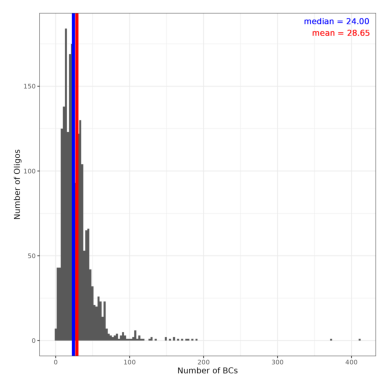

In [15]:
img = plt.imread(os.path.join(results_dir, "assignMPRAworkshop/statistic/assignment.default.png"))
plt.imshow(img)
plt.axis("off")

The median number of barcodes is 24. We usually require each tested sequence to have at least 10 barcodes associated.

We will now take a look at the actual output file of the assignment run. Which is a sorted table of `barcodes`, their assigned `sequence IDs`, information about the `quality` of the alignment (fwd/rev reads to designed oligos) and how often this barcode was assigned to this sequence compared to the total number this barcode was observed in the experiment. The information in the quality field is derived from the SAM/BAM output (https://samtools.github.io/hts-specs/SAMv1.pdf) and represents a concatenation of the SAM position, cigar, NM, AM and mapQ.

In [16]:
assignment = os.path.join(results_dir, "assignMPRAworkshop/assignment_barcodes.default.tsv.gz")
!zcat "{assignment}" | awk 'NR <= 10 {{print $$0}}'

AAAAAAAAAGAAGGG	oligo_006589	16;200=;NM:i:0;AM:i:45;45	5/5
AAAAAAAAATCGATC	oligo_006917	16;161=1X38=;NM:i:1;AM:i:44;44	3/3
AAAAAAAAATGATCT	oligo_211468	16;190=1X9=;NM:i:1;AM:i:44;44	4/4
AAAAAAAACACATGA	oligo_005412	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACAGTAAG	oligo_006290	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACATAGTT	oligo_006471	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACCAAATA	oligo_189277	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACGAACAG	oligo_005299	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAACTATGTT	oligo_005948	16;200=;NM:i:0;AM:i:45;45	3/3
AAAAAAAAGAAAAAG	oligo_144933	17;199=;NM:i:0;AM:i:45;45	3/3


We would like to know how many different oligos have been included in the final assignment.\
When we compare this number to the number of sequences in our design, we can get a feeling of how many sequences were able to get assigned with their barcodes. This has implications for the proportion of targets that we can eventually analyse and whether each target is supported with sufficiently many barcodes. This information is important for the experiment overall and analyzing the counts of each individual replicate.

In [17]:
assigned_sequences = !zcat "{assignment}" | awk -F'\t' '{{names[$$2]++}} END {{print length(names)}}'

assigned_sequences = int(assigned_sequences[0])
print("Number of sequences we were able to assign: %s"%(assigned_sequences))

designed_sequences = !cat "MPRAsnakeflow_tutorial/example_data/design/workshop_design.fa" | grep -v ">" | wc -l
designed_sequences = int(designed_sequences[0])
print("Number of sequences in the initial design: %s"%(designed_sequences))

print(r"Conclusion: %s%% sequences of our initial design can be used in the experimental/counting step"%(round(assigned_sequences/designed_sequences * 100, 1)))

Number of sequences we were able to assign: 2060
Number of sequences in the initial design: 2104
Conclusion: 97.9% sequences of our initial design can be used in the experimental/counting step


### QC report

We have a QC report for the assigment as well for the experiment workflow . For our run you can find it here:

[MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html](MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html)

The QC report gives a nice overview of the assignment run and might be the first thing you will look on.

In [18]:
from IPython.display import IFrame

IFrame(src='./MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html', width=700, height=600)